In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True, #텐서와 라벨과 함께 튜플 형태로 저장하라
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



1


2023-04-28 12:15:30.337162: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


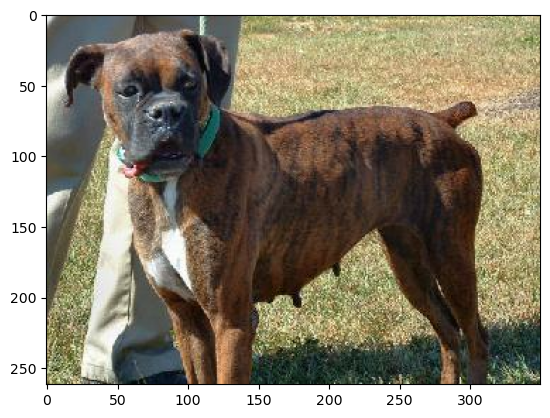

In [5]:
for image, label in raw_train.take(1):
    plt.imshow(image)
    print(label.numpy())

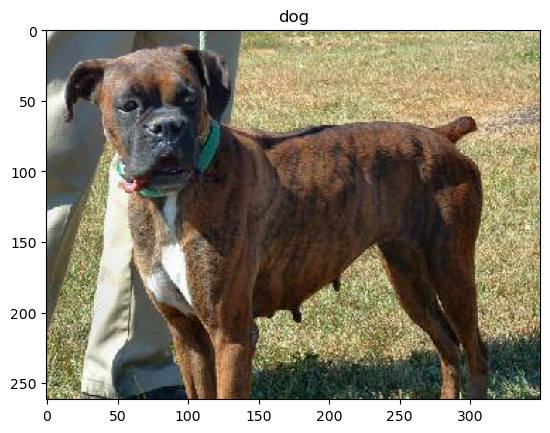

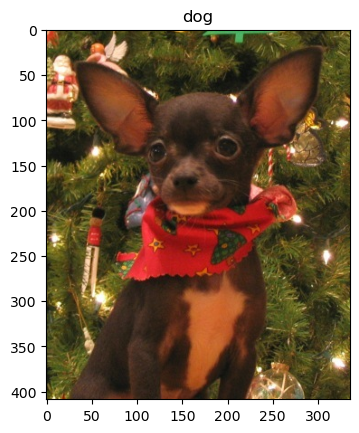

In [7]:
get_label_name = metadata.features['label'].int2str

for image,label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

### 이미지 전처리함수 map 으로 적용

In [20]:
IMG_SIZE = 160 #모든 이미지는 160x160으로

@tf.autograph.experimental.do_not_convert
def format_example(image,label):
    image = tf.cast(image,tf.float32)
    image = (image/127.5) -1 #0-255 픽셀의 중앙값으로 나눈다. 0과 2 사이 숫자로 스케일링되고, -1로 차감하여 -1과 1로 만든다.
    image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
    return image,label

In [21]:
train = raw_train.map(format_example) #대용량 처리시 map 유리
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)


### 베이스모델 구성

In [22]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [24]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, #출력 fc 가져올것인지?
                                               weights='imagenet' #어떤 종류로 학습된 모델 가중치?
                                               )
#MobileNet 모델 불러오기
#include_top = 내 모델의 출력값을 커스터마이징 해야함


9406464/9406464 [==============================] - 0s 0us/step


In [26]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape
#배치 하나 불러와서 테스트
feature_batch = base_model(image_batch)
print(IMG_SHAPE)
print(feature_batch.shape)

#160*160*3 이미지를 5*5*1280 특징 블록으로 변환
#32개의 이미지, 가로세로 5,5, 1280 채널

(160, 160, 3)
(32, 5, 5, 1280)


In [27]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [29]:
### Global Average Pooling Layer 적용
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print('feature_batch : ',feature_batch.shape)
print('g.b average pool2d 이후 : ',feature_batch_average.shape)

#Global Average Pooling 2D 층을 사용하여 이미지 한개 당 1280개의 요소 벡터로 변환한다.

feature_batch :  (32, 5, 5, 1280)
g.b average pool2d 이후 :  (32, 1280)


In [35]:
#Dense 층을 사용하여 특징을 이미지당 단일 예측
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

#양수는 1을, 음수는 0을 예측하는 2진분류
prediction_batch

(32, 1)


<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-0.11364938],
       [ 0.75188696],
       [-1.2164606 ],
       [ 0.6252044 ],
       [-1.092493  ],
       [-0.5166615 ],
       [ 0.7928256 ],
       [-1.1972024 ],
       [ 0.75666046],
       [ 0.10628328],
       [-0.89908147],
       [-0.19100147],
       [-0.7331668 ],
       [-1.9583822 ],
       [-0.70882   ],
       [-0.41355875],
       [-0.48843244],
       [-1.2106476 ],
       [ 0.05741787],
       [-0.47252417],
       [-1.1144676 ],
       [ 0.5074669 ],
       [ 0.1955971 ],
       [-1.7191229 ],
       [-0.0748786 ],
       [-0.31162918],
       [-0.8858416 ],
       [ 0.45187375],
       [ 0.1387006 ],
       [-0.02359061],
       [ 0.40778548],
       [-0.0307309 ]], dtype=float32)>

In [34]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [39]:
base_learning_rate = 0.0001

#m1에서 느린 이슈로 legacy 활용
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
              )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
#미학습 성능
initial_epochs = 10
validation_steps = 20
loss0,accuracy0 = model.evaluate(validation_batches,steps=validation_steps)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 5/20 [======>.......................] - ETA: 1s - loss: 0.7002 - accuracy: 0.5188

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


17/20 [========================>.....] - ETA: 0s - loss: 0.6862 - accuracy: 0.5643

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


20/20 [==============================] - 3s 76ms/step - loss: 0.6709 - accuracy: 0.5750


### 학습

In [41]:
#trainable weights가 1200여개 인 상황에서 학습
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
166/582 [=======>......................] - ETA: 33s - loss: 0.3770 - accuracy: 0.8093

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 30s - loss: 0.3480 - accuracy: 0.8302

208/582 [=========>....................] - ETA: 29s - loss: 0.3410 - accuracy: 0.8346

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 23s - loss: 0.2949 - accuracy: 0.8619

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.2193 - accuracy: 0.9038

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 6s - loss: 0.2159 - accuracy: 0.9056

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.2137 - accuracy: 0.9067

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.2073 - accuracy: 0.9098

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.2059 - accuracy: 0.9106

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9143

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 52s 86ms/step - loss: 0.1983 - accuracy: 0.9143 - val_loss: 0.0895 - val_accuracy: 0.9673
Epoch 2/10
165/582 [=======>......................] - ETA: 31s - loss: 0.0805 - accuracy: 0.9739

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 28s - loss: 0.0804 - accuracy: 0.9726

207/582 [=========>....................] - ETA: 28s - loss: 0.0805 - accuracy: 0.9724

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 23s - loss: 0.0810 - accuracy: 0.9710

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 7s - loss: 0.0751 - accuracy: 0.9730

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 6s - loss: 0.0750 - accuracy: 0.9731

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 5s - loss: 0.0749 - accuracy: 0.9732

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 3s - loss: 0.0738 - accuracy: 0.9738

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 2s - loss: 0.0734 - accuracy: 0.9740

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9741

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 51s 87ms/step - loss: 0.0728 - accuracy: 0.9741 - val_loss: 0.0661 - val_accuracy: 0.9764
Epoch 3/10
166/582 [=======>......................] - ETA: 31s - loss: 0.0632 - accuracy: 0.9785

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 29s - loss: 0.0633 - accuracy: 0.9785

209/582 [=========>....................] - ETA: 29s - loss: 0.0628 - accuracy: 0.9782

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 23s - loss: 0.0620 - accuracy: 0.9770

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.0607 - accuracy: 0.9781

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 6s - loss: 0.0608 - accuracy: 0.9780

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.0605 - accuracy: 0.9781

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.0594 - accuracy: 0.9784

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.0592 - accuracy: 0.9785

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9788

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 53s 90ms/step - loss: 0.0588 - accuracy: 0.9788 - val_loss: 0.0582 - val_accuracy: 0.9798
Epoch 4/10
165/582 [=======>......................] - ETA: 36s - loss: 0.0545 - accuracy: 0.9814

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 33s - loss: 0.0548 - accuracy: 0.9811

207/582 [=========>....................] - ETA: 32s - loss: 0.0532 - accuracy: 0.9817

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 27s - loss: 0.0568 - accuracy: 0.9795

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.0540 - accuracy: 0.9805

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 7s - loss: 0.0543 - accuracy: 0.9802

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 6s - loss: 0.0542 - accuracy: 0.9801

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 3s - loss: 0.0534 - accuracy: 0.9805

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 3s - loss: 0.0532 - accuracy: 0.9807

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9809

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 58s 98ms/step - loss: 0.0528 - accuracy: 0.9809 - val_loss: 0.0543 - val_accuracy: 0.9798
Epoch 5/10
166/582 [=======>......................] - ETA: 35s - loss: 0.0507 - accuracy: 0.9823

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 32s - loss: 0.0506 - accuracy: 0.9822

208/582 [=========>....................] - ETA: 31s - loss: 0.0497 - accuracy: 0.9821

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 26s - loss: 0.0530 - accuracy: 0.9807

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.0505 - accuracy: 0.9819

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 6s - loss: 0.0504 - accuracy: 0.9818

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.0502 - accuracy: 0.9819

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0499 - accuracy: 0.9820

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0499 - accuracy: 0.9820

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9822

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 56s 94ms/step - loss: 0.0495 - accuracy: 0.9822 - val_loss: 0.0519 - val_accuracy: 0.9798
Epoch 6/10
166/582 [=======>......................] - ETA: 36s - loss: 0.0457 - accuracy: 0.9831

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 33s - loss: 0.0454 - accuracy: 0.9834

208/582 [=========>....................] - ETA: 32s - loss: 0.0468 - accuracy: 0.9832

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 25s - loss: 0.0480 - accuracy: 0.9828

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.0479 - accuracy: 0.9827

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 6s - loss: 0.0480 - accuracy: 0.9827

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.0478 - accuracy: 0.9828

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0476 - accuracy: 0.9827

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0472 - accuracy: 0.9829

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9829

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 55s 93ms/step - loss: 0.0470 - accuracy: 0.9829 - val_loss: 0.0502 - val_accuracy: 0.9815
Epoch 7/10
166/582 [=======>......................] - ETA: 34s - loss: 0.0473 - accuracy: 0.9836

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 31s - loss: 0.0462 - accuracy: 0.9841

208/582 [=========>....................] - ETA: 30s - loss: 0.0468 - accuracy: 0.9836

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 24s - loss: 0.0486 - accuracy: 0.9827

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.0461 - accuracy: 0.9836

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 6s - loss: 0.0464 - accuracy: 0.9833

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.0462 - accuracy: 0.9833

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0461 - accuracy: 0.9834

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0458 - accuracy: 0.9836

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9836

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 91ms/step - loss: 0.0454 - accuracy: 0.9836 - val_loss: 0.0491 - val_accuracy: 0.9824
Epoch 8/10
166/582 [=======>......................] - ETA: 34s - loss: 0.0432 - accuracy: 0.9842

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 31s - loss: 0.0450 - accuracy: 0.9835

209/582 [=========>....................] - ETA: 31s - loss: 0.0446 - accuracy: 0.9836

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 24s - loss: 0.0459 - accuracy: 0.9835

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.0455 - accuracy: 0.9839

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 6s - loss: 0.0451 - accuracy: 0.9840

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.0450 - accuracy: 0.9839

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.0439 - accuracy: 0.9843

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.0440 - accuracy: 0.9842

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9841

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 91ms/step - loss: 0.0440 - accuracy: 0.9841 - val_loss: 0.0483 - val_accuracy: 0.9828
Epoch 9/10
166/582 [=======>......................] - ETA: 33s - loss: 0.0425 - accuracy: 0.9851

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 31s - loss: 0.0433 - accuracy: 0.9852

209/582 [=========>....................] - ETA: 30s - loss: 0.0440 - accuracy: 0.9847

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 24s - loss: 0.0458 - accuracy: 0.9840

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.0441 - accuracy: 0.9849

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 6s - loss: 0.0437 - accuracy: 0.9849

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.0438 - accuracy: 0.9848

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.0432 - accuracy: 0.9849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.0431 - accuracy: 0.9849

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9848

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 91ms/step - loss: 0.0430 - accuracy: 0.9848 - val_loss: 0.0475 - val_accuracy: 0.9824
Epoch 10/10
166/582 [=======>......................] - ETA: 34s - loss: 0.0422 - accuracy: 0.9849

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 31s - loss: 0.0430 - accuracy: 0.9844

208/582 [=========>....................] - ETA: 30s - loss: 0.0434 - accuracy: 0.9845

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 24s - loss: 0.0450 - accuracy: 0.9836

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.0435 - accuracy: 0.9844

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 6s - loss: 0.0430 - accuracy: 0.9845

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 5s - loss: 0.0429 - accuracy: 0.9844

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0428 - accuracy: 0.9845

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0426 - accuracy: 0.9845

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9847

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 55s 92ms/step - loss: 0.0420 - accuracy: 0.9847 - val_loss: 0.0470 - val_accuracy: 0.9832


In [48]:
history.history

{'loss': [0.1982651650905609,
  0.07277996093034744,
  0.05880669504404068,
  0.052793681621551514,
  0.04945642128586769,
  0.04698875918984413,
  0.04541587829589844,
  0.0439738854765892,
  0.04302021488547325,
  0.04204346612095833],
 'accuracy': [0.9143471121788025,
  0.9740999341011047,
  0.9787748456001282,
  0.9808704853057861,
  0.9821601510047913,
  0.9829124212265015,
  0.983610987663269,
  0.9840945601463318,
  0.984846830368042,
  0.984739363193512],
 'val_loss': [0.08953197300434113,
  0.06610798090696335,
  0.05822296068072319,
  0.05427421256899834,
  0.051861587911844254,
  0.05021632835268974,
  0.04910196736454964,
  0.04825931042432785,
  0.04750155657529831,
  0.04700128361582756],
 'val_accuracy': [0.9673258662223816,
  0.9763542413711548,
  0.9797936081886292,
  0.9797936081886292,
  0.9797936081886292,
  0.9815133213996887,
  0.9823731780052185,
  0.9828031063079834,
  0.9823731780052185,
  0.9832330346107483]}

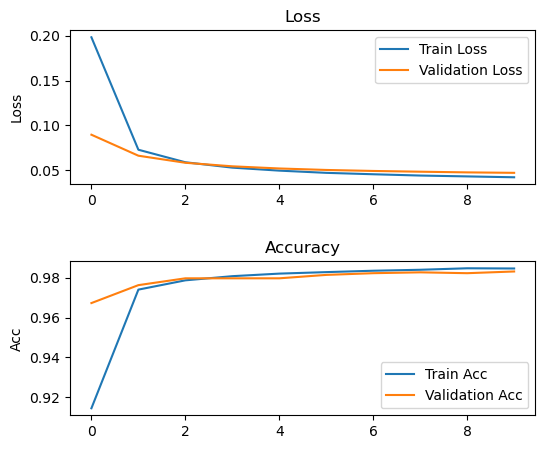

In [62]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Figure 생성
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,5),gridspec_kw={'hspace': 0.5})

    # Train loss 및 validation loss 그래프 그리기
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Loss')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Train accuracy 및 validation accuracy 그래프 그리기
    axes[1].plot(history.history['accuracy'], label='Train Acc')
    axes[1].plot(history.history['val_accuracy'], label='Validation Acc')
    axes[1].set_title('Accuracy')
    axes[1].set_ylabel('Acc')
    axes[1].legend()

    # 그래프 출력
    plt.show()

plot_history(history)

### fine tuning
입력에 가까운 값들을 고정시키고, 출력에 가까운 값들을 튜닝한다는 것은 세밀한 묘사 학습은 그대로 두되, 큰 그림을 보는 부분을 학습한다는 뜻. 

In [67]:
base_model.trainable = True
print('number of layers needs to be trained : ',len(base_model.layers))

#fine tune at 이전 100개의 층을 고정
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable=False


number of layers needs to be trained :  154


In [74]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy']
              )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [76]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1], #이전 모델에서 학습했던 에포크를 건너 뛴다.
                         validation_data = validation_batches
                         )

Epoch 10/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
165/582 [=======>......................] - ETA: 51s - loss: 0.2165 - accuracy: 0.9244

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 46s - loss: 0.2014 - accuracy: 0.9291

207/582 [=========>....................] - ETA: 45s - loss: 0.1988 - accuracy: 0.9301

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 36s - loss: 0.1731 - accuracy: 0.9375

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 10s - loss: 0.1390 - accuracy: 0.9485

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 9s - loss: 0.1380 - accuracy: 0.9489

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 8s - loss: 0.1370 - accuracy: 0.9492

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.1351 - accuracy: 0.9498

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 4s - loss: 0.1341 - accuracy: 0.9502

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9512WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x110caaee0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 83s 131ms/step - loss: 0.1302 - accuracy: 0.9512 - val_loss: 0.0699 - val_accuracy: 0.9794
Epoch 11/20
165/582 [=======>......................] - ETA: 48s - loss: 0.0753 - accuracy: 0.9676

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 44s - loss: 0.0752 - accuracy: 0.9680

207/582 [=========>....................] - ETA: 43s - loss: 0.0738 - accuracy: 0.9684

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 36s - loss: 0.0738 - accuracy: 0.9690

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 11s - loss: 0.0682 - accuracy: 0.9723

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 9s - loss: 0.0675 - accuracy: 0.9725

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 8s - loss: 0.0676 - accuracy: 0.9725

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0672 - accuracy: 0.9729

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 4s - loss: 0.0672 - accuracy: 0.9728

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9728

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 78s 133ms/step - loss: 0.0668 - accuracy: 0.9728 - val_loss: 0.0544 - val_accuracy: 0.9824
Epoch 12/20
165/582 [=======>......................] - ETA: 59s - loss: 0.0476 - accuracy: 0.9788

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 53s - loss: 0.0490 - accuracy: 0.9791

207/582 [=========>....................] - ETA: 51s - loss: 0.0525 - accuracy: 0.9786

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 39s - loss: 0.0546 - accuracy: 0.9778

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 12s - loss: 0.0525 - accuracy: 0.9790

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 10s - loss: 0.0533 - accuracy: 0.9789

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0533 - accuracy: 0.9788

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0522 - accuracy: 0.9794

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 4s - loss: 0.0520 - accuracy: 0.9795

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9797

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 81s 138ms/step - loss: 0.0521 - accuracy: 0.9797 - val_loss: 0.0492 - val_accuracy: 0.9845
Epoch 13/20
165/582 [=======>......................] - ETA: 59s - loss: 0.0399 - accuracy: 0.9843

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 55s - loss: 0.0416 - accuracy: 0.9834

207/582 [=========>....................] - ETA: 54s - loss: 0.0422 - accuracy: 0.9838

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 43s - loss: 0.0413 - accuracy: 0.9841

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 13s - loss: 0.0394 - accuracy: 0.9854

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 11s - loss: 0.0387 - accuracy: 0.9856

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 10s - loss: 0.0391 - accuracy: 0.9853

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 6s - loss: 0.0389 - accuracy: 0.9854

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0391 - accuracy: 0.9854

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9852

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 89s 152ms/step - loss: 0.0392 - accuracy: 0.9852 - val_loss: 0.0475 - val_accuracy: 0.9811
Epoch 14/20
165/582 [=======>......................] - ETA: 1:04 - loss: 0.0266 - accuracy: 0.9903

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 59s - loss: 0.0286 - accuracy: 0.9898

207/582 [=========>....................] - ETA: 57s - loss: 0.0292 - accuracy: 0.9899

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 44s - loss: 0.0296 - accuracy: 0.9894

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 13s - loss: 0.0292 - accuracy: 0.9891

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 11s - loss: 0.0294 - accuracy: 0.9891

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0294 - accuracy: 0.9892 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 6s - loss: 0.0287 - accuracy: 0.9896

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0288 - accuracy: 0.9895

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9897

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 90s 154ms/step - loss: 0.0285 - accuracy: 0.9897 - val_loss: 0.0471 - val_accuracy: 0.9837
Epoch 15/20
165/582 [=======>......................] - ETA: 1:03 - loss: 0.0277 - accuracy: 0.9894

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 57s - loss: 0.0279 - accuracy: 0.9902

207/582 [=========>....................] - ETA: 55s - loss: 0.0281 - accuracy: 0.9900

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 43s - loss: 0.0315 - accuracy: 0.9887

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 13s - loss: 0.0266 - accuracy: 0.9901

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 11s - loss: 0.0265 - accuracy: 0.9903

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0266 - accuracy: 0.9902 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 6s - loss: 0.0259 - accuracy: 0.9905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0257 - accuracy: 0.9906

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9909

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 88s 149ms/step - loss: 0.0251 - accuracy: 0.9909 - val_loss: 0.0503 - val_accuracy: 0.9837
Epoch 16/20
165/582 [=======>......................] - ETA: 52s - loss: 0.0243 - accuracy: 0.9913

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 47s - loss: 0.0241 - accuracy: 0.9919

207/582 [=========>....................] - ETA: 46s - loss: 0.0248 - accuracy: 0.9918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 37s - loss: 0.0250 - accuracy: 0.9912

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 12s - loss: 0.0219 - accuracy: 0.9920

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 10s - loss: 0.0216 - accuracy: 0.9921

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0214 - accuracy: 0.9922

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0211 - accuracy: 0.9923

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0213 - accuracy: 0.9922

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9925

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 84s 142ms/step - loss: 0.0207 - accuracy: 0.9925 - val_loss: 0.0486 - val_accuracy: 0.9828
Epoch 17/20
165/582 [=======>......................] - ETA: 59s - loss: 0.0133 - accuracy: 0.9960

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 54s - loss: 0.0148 - accuracy: 0.9959

207/582 [=========>....................] - ETA: 53s - loss: 0.0144 - accuracy: 0.9961

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 42s - loss: 0.0158 - accuracy: 0.9951

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 12s - loss: 0.0153 - accuracy: 0.9951

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 11s - loss: 0.0153 - accuracy: 0.9952

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0151 - accuracy: 0.9952

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0153 - accuracy: 0.9951

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0153 - accuracy: 0.9951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9950

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 86s 146ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.0503 - val_accuracy: 0.9815
Epoch 18/20
165/582 [=======>......................] - ETA: 55s - loss: 0.0161 - accuracy: 0.9932

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 51s - loss: 0.0161 - accuracy: 0.9937

207/582 [=========>....................] - ETA: 50s - loss: 0.0156 - accuracy: 0.9938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 40s - loss: 0.0145 - accuracy: 0.9943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 12s - loss: 0.0124 - accuracy: 0.9955

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 10s - loss: 0.0123 - accuracy: 0.9955

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0122 - accuracy: 0.9956

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0118 - accuracy: 0.9958

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0118 - accuracy: 0.9958

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9958

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 85s 145ms/step - loss: 0.0115 - accuracy: 0.9958 - val_loss: 0.0568 - val_accuracy: 0.9807
Epoch 19/20
165/582 [=======>......................] - ETA: 55s - loss: 0.0085 - accuracy: 0.9968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 51s - loss: 0.0092 - accuracy: 0.9968

207/582 [=========>....................] - ETA: 50s - loss: 0.0102 - accuracy: 0.9967

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 40s - loss: 0.0113 - accuracy: 0.9962

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 12s - loss: 0.0100 - accuracy: 0.9969

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 11s - loss: 0.0099 - accuracy: 0.9970

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0097 - accuracy: 0.9971

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0099 - accuracy: 0.9970

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0101 - accuracy: 0.9970

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9971

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 85s 145ms/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.0528 - val_accuracy: 0.9837
Epoch 20/20
165/582 [=======>......................] - ETA: 56s - loss: 0.0072 - accuracy: 0.9977

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 51s - loss: 0.0103 - accuracy: 0.9964

207/582 [=========>....................] - ETA: 50s - loss: 0.0100 - accuracy: 0.9965

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 40s - loss: 0.0095 - accuracy: 0.9968

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 12s - loss: 0.0075 - accuracy: 0.9978

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 10s - loss: 0.0074 - accuracy: 0.9977

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0073 - accuracy: 0.9978

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0074 - accuracy: 0.9978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0074 - accuracy: 0.9978

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9978

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 86s 146ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.0552 - val_accuracy: 0.9841


In [77]:
acc = history.history['accuracy']
acc += history_fine.history['accuracy']
val_acc = history.history['val_accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss']
loss += history_fine.history['loss']
val_loss = history.history['val_loss']
val_loss += history_fine.history['val_loss']

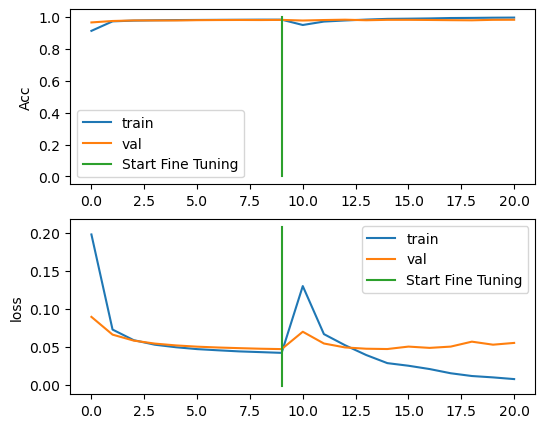

In [90]:
def checker(acc,val_acc,loss,val_loss):
    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(6,5))

    axes[0].plot(acc,label='train')
    axes[0].plot(val_acc,label='val')
    axes[0].plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
    axes[0].set_ylabel('Acc')
    axes[0].legend()
    # axes[0].ylim([0,1.0])

    axes[1].plot(loss,label='train')
    axes[1].plot(val_loss,label='val')
    axes[1].plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
    axes[1].set_ylabel('loss')
    axes[1].legend()

checker(acc,val_acc,loss,val_loss)
